In [22]:
import DeconV as dv

import torch
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Download data from: https://xuranw.github.io/MuSiC/articles/pages/data.html
# ExpressionSet: 'XinT2Deset.rds' (Single cell RNA-seq data of pancreatic islet from healthy and diseased individuals(Xin et al.))
# ExpressionSet: 'EMTABesethealthy.rds' (Single cell RNA-seq data of pancreatic islets from healthy individuals (Segerstolpe et al.))
# Use the rds_to_csv.r script to convert to csv

reference_file = "../../data/xin/sc.txt"
reference_mdata_file = "../../data/xin/pdata.txt"
bulk_file = "../../data/xin/bulk.txt"
cell_types = ["alpha", "delta", "gamma", "beta"]

sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white')
sc.settings.figdir = "../deconV/figures/"

### 1. Read data + basic QC

In [24]:
adata = sc.read_csv(reference_file, first_column_names=True, delimiter="\t")

pheno_df = pd.read_table(reference_mdata_file, index_col=0)
pheno_df.index.name = None
common_cells = list(set(pheno_df.index.tolist()) & set(adata.obs_names.tolist()))


adata = adata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
adata.obs["labels"] = pheno_df["cellType"].tolist()
adata.obs["labels"] = adata.obs["labels"].astype("category")

adata = adata[adata.obs["labels"].astype("str").isin(cell_types), :].copy()

print(adata.obs.groupby("labels").size())

bulk_df = pd.read_table(bulk_file, index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_counts=100)

labels
alpha    443
beta     171
delta     59
gamma     75
dtype: int64
bulk RNA-seq data - samples: 18, genes: 39849


### 2. Combine single-cell and bulk into same AnnData object

In [25]:
adata = dv.tl.combine(adata, bulk_df)

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=None)
adata.layers["ncounts"] = adata.X.copy()
sc.pp.log1p(adata)

# sc.pp.highly_variable_genes(adata, n_top_genes=10000, subset=True)
adata.obsm["lib_size"] = adata.layers["counts"].sum(1)
adata.shape

scRNA-seq data - cells: 748, genes: 15029
bulk RNA-seq data - samples: 18, genes: 15029


(748, 15029)

### 3. Choose device to run on

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 4. Initialize model

In [27]:
decon = dv.DeconV(
    adata, cell_type_key="labels",  # cell_type_key is the column key in adata.obs that holds the cell type annotations 
    dropout_type="separate",        # separate, shared, or None
    model_type="gamma",             # Gamma, Beta, nb, lognormal, or static    
    device=device
)

### 5. Train the reference model

In [28]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999, layer="counts")

Rounding counts to integers.


100%|██████████| 2000/2000 [00:41<00:00, 48.63it/s, loss=3.68e+05, lr=1.35e-02]


### 6. Deconvolute

In [29]:
proportions = decon.deconvolute(model_dropout=True, lrd=0.999, lr=0.1, num_epochs=1000)

100%|██████████| 1000/1000 [00:05<00:00, 187.55it/s, loss=3.42e+09, lr=3.68e-02]


In [30]:
proportions_df = pd.DataFrame(proportions.cpu().numpy(), index=adata.uns["bulk_samples"], columns=decon.cell_types)
proportions_df

,alpha,beta,delta,gamma
Non T2D 1,0.513533,0.364355,0.040526,0.081586
Non T2D 2,0.171258,0.611896,0.026351,0.190496
Non T2D 3,0.745249,0.150561,0.047709,0.056482
Non T2D 5,0.535567,0.350991,0.072054,0.041388
Non T2D 6,0.851376,0.085045,0.062088,0.001492
Non T2D 7,0.362368,0.436756,0.000002,0.200873
Non T2D 8,0.399639,0.319906,0.091482,0.188973
Non T2D 9,0.689740,0.153358,0.003400,0.153503
Non T2D 10,0.570662,0.388398,0.040573,0.000367
Non T2D 11,0.662778,0.263061,0.010540,0.063621


### 7. Visualize results

In [31]:
df = decon.get_results_df()
df

,sample,cell_type,est,min,max
0,Non T2D 1,alpha,0.513533,0.051043,0.052794
1,Non T2D 2,alpha,0.171258,0.033312,0.037541
2,Non T2D 3,alpha,0.745249,0.037613,0.036314
3,Non T2D 5,alpha,0.535567,0.064470,0.064370
4,Non T2D 6,alpha,0.851376,0.042680,0.038480
...,...,...,...,...,...
67,T2D 3,gamma,0.130060,0.037084,0.042512
68,T2D 1,gamma,0.388936,0.052539,0.052684
69,T2D 4,gamma,0.010004,0.008956,0.019343
70,T2D 5,gamma,0.001960,0.001895,0.004853


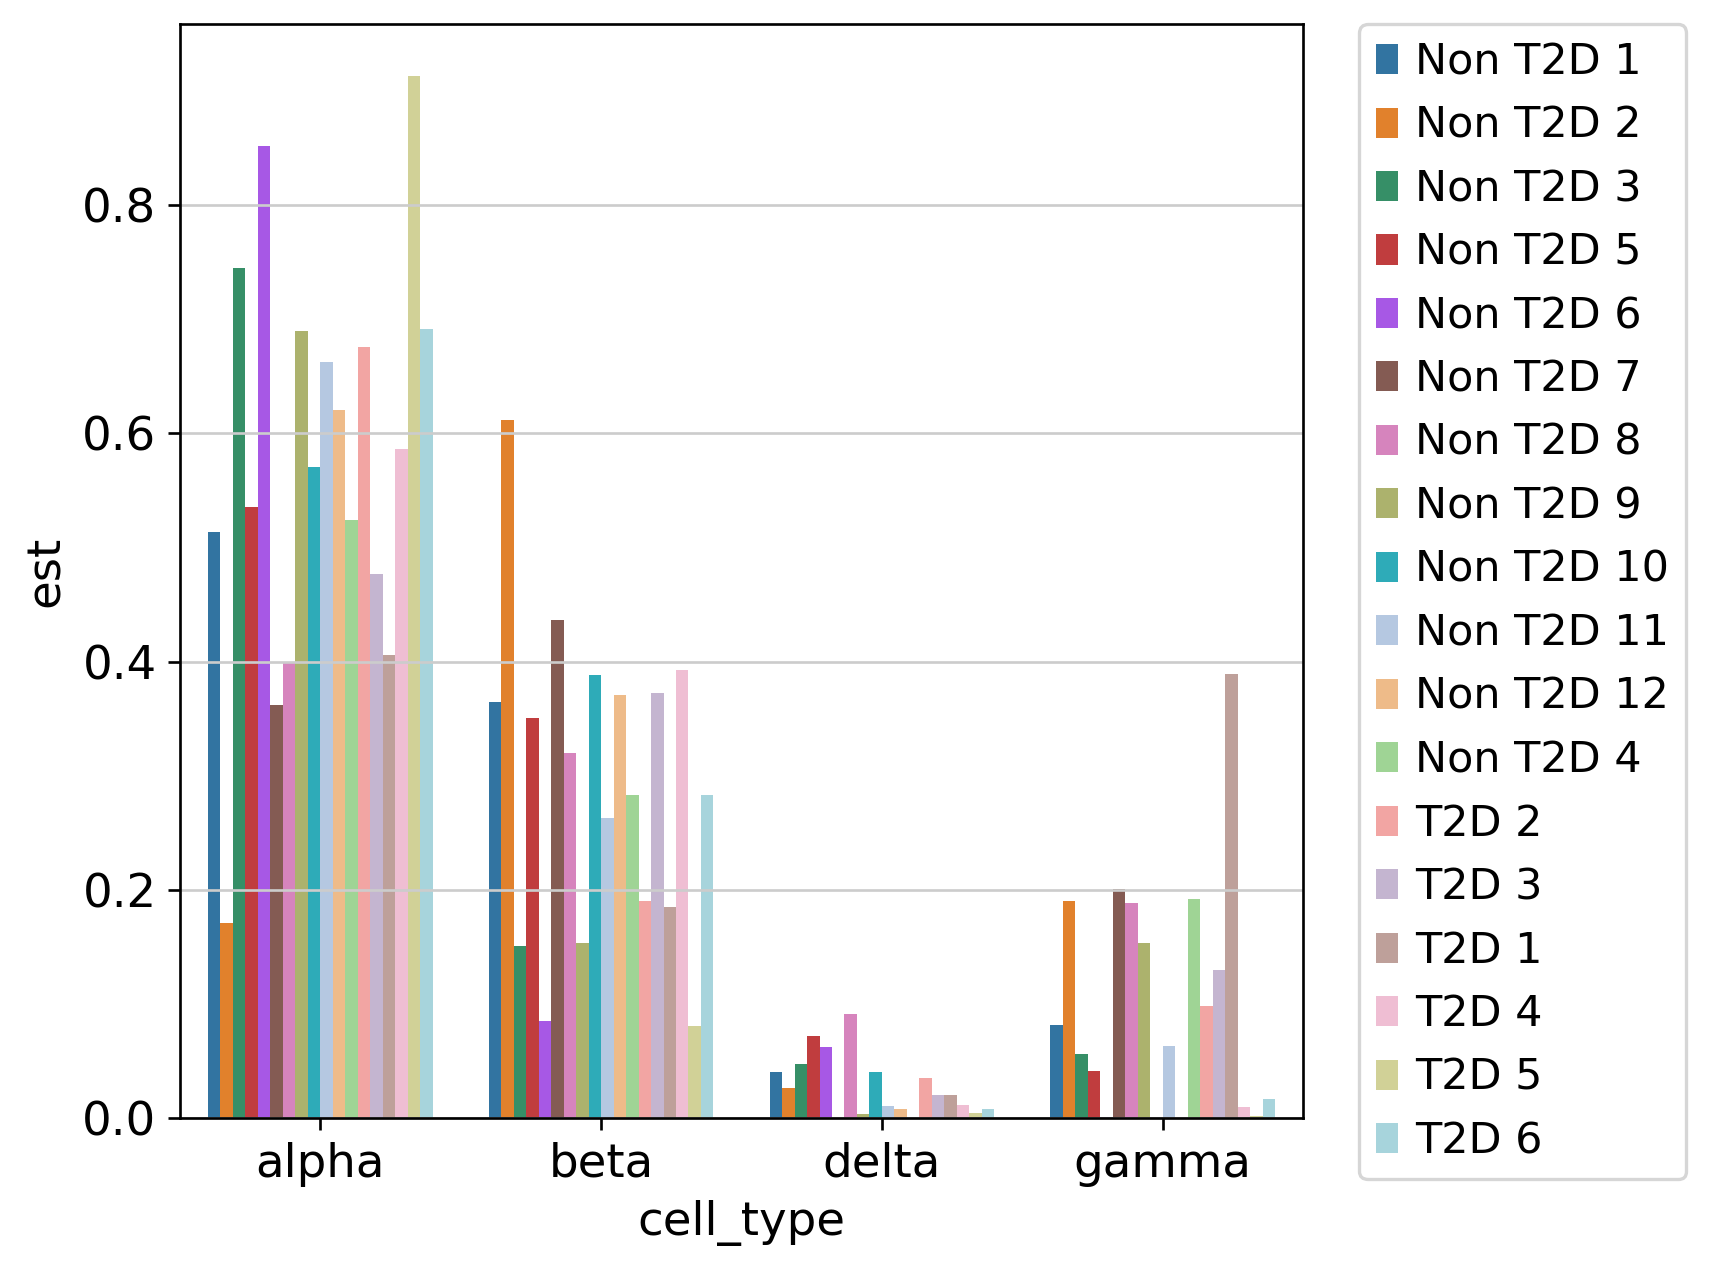

In [32]:
f, ax = plt.subplots(figsize=(6,6), dpi=120)

sns.barplot(
    data=df, x="cell_type", y="est", hue="sample", ax=ax
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<AxesSubplot: xlabel='cell_type', ylabel='est'>

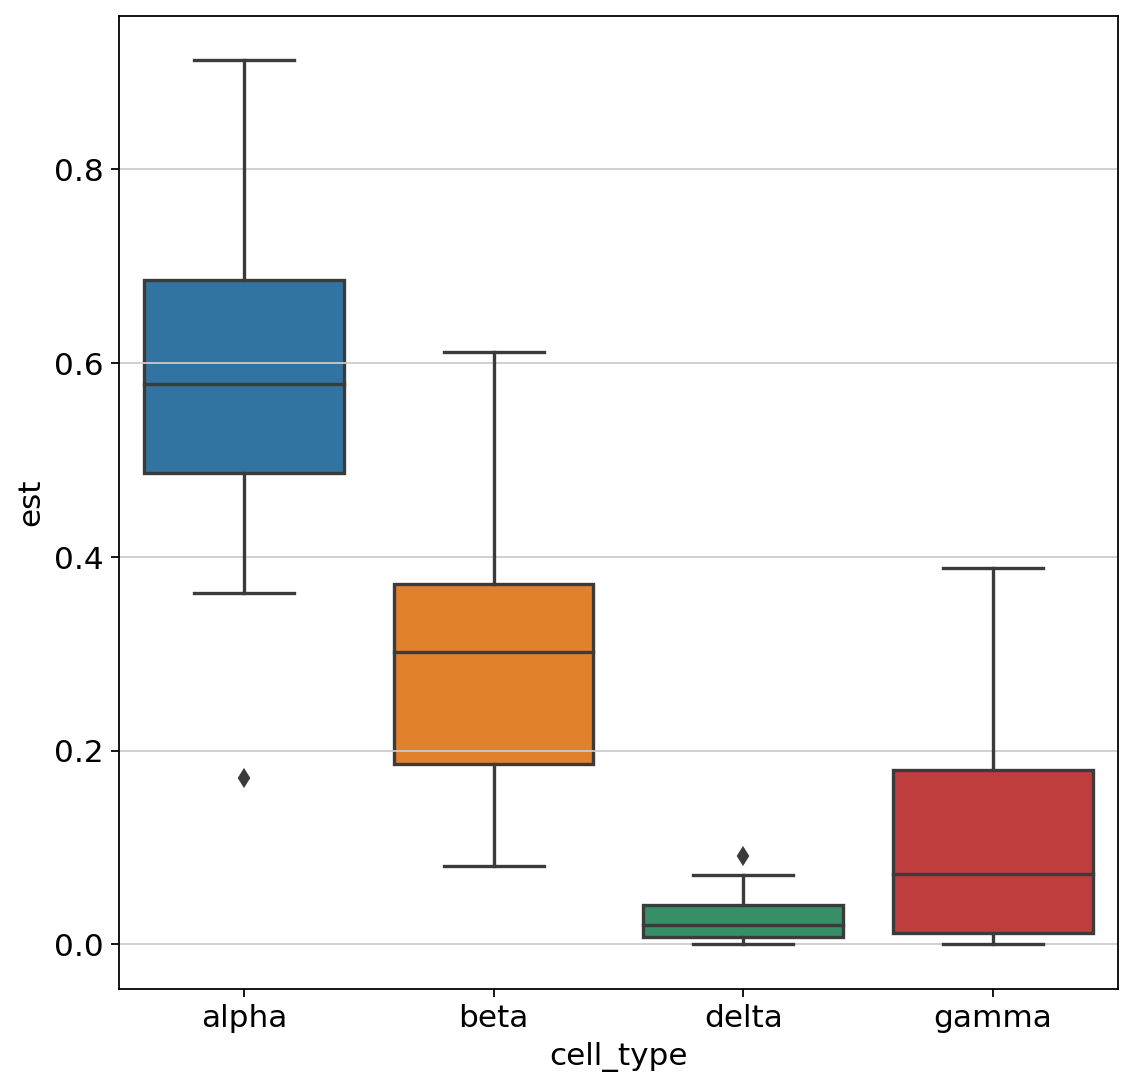

In [33]:
# Summarize proportions with boxplot
sns.boxplot(
    data=df, x="cell_type", y="est"
)

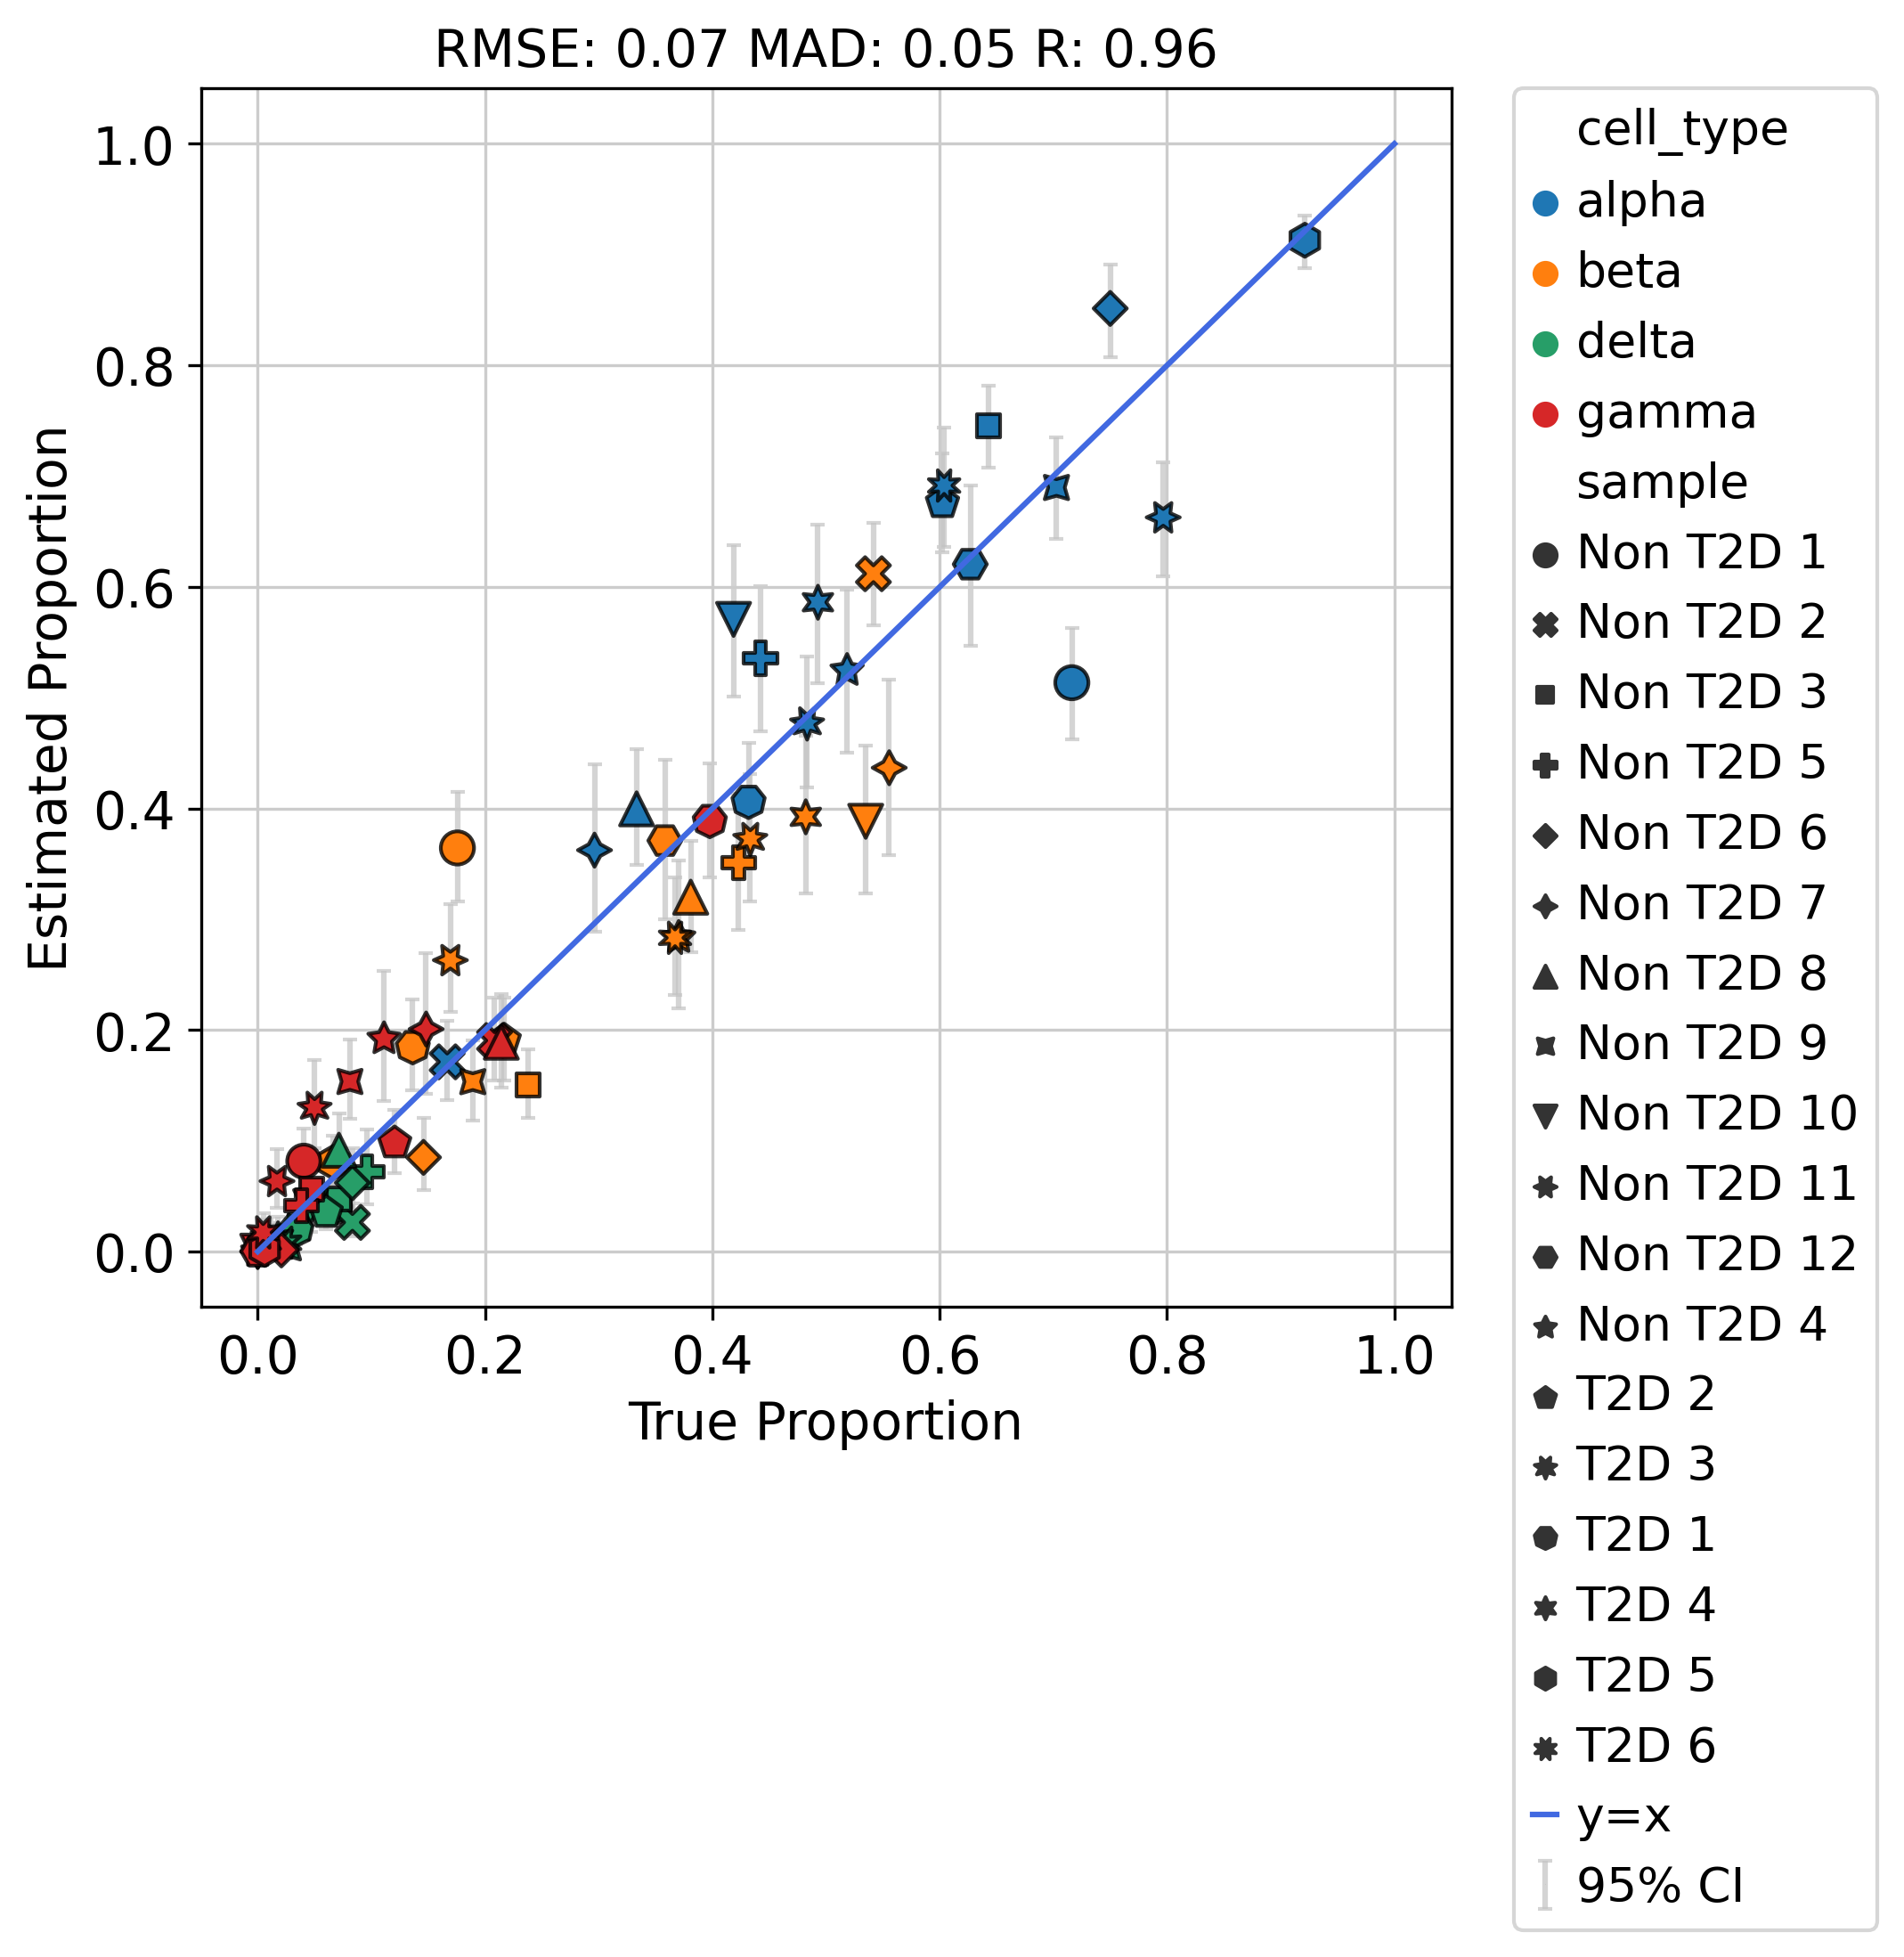

(0.06606367065142112, 0.04710067563164877, 0.9633415552995415)

In [34]:
# Ground truth proportions
true_df = pd.read_table("../../data/xin/proportions.txt", index_col=0)
true_df.sort_index(axis="columns", inplace=True)

res_df = decon.get_results_df()
res_df["true"] = true_df.melt()["value"]
dv.pl.xypredictions(res_df, figsize=(6,6), dpi=150)

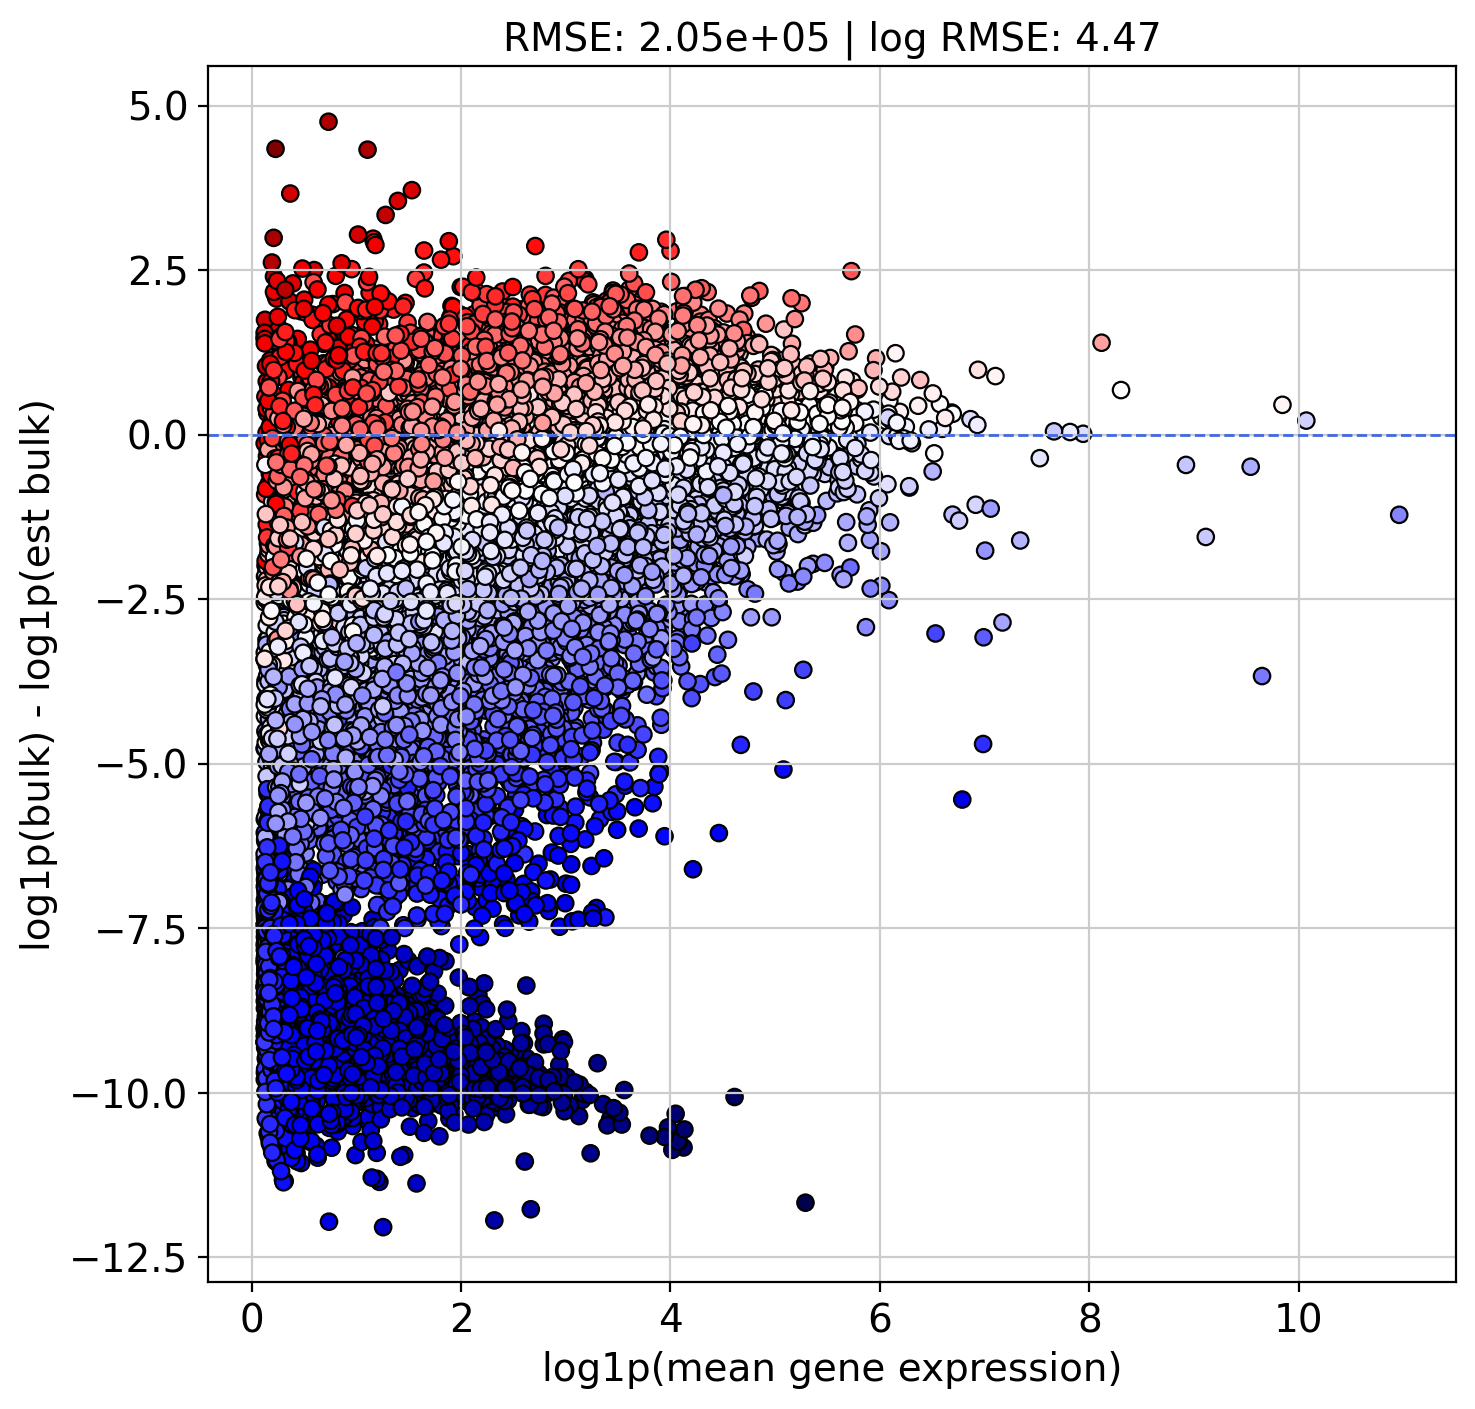

In [35]:
# Visualize objective function
dv.pl.prediction_plot(decon, 1)